In [1]:
import numpy as np
import pyblp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import default_rng
from scipy.optimize import root
import scipy.sparse as sp


import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from pathlib import Path

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.2'

In [2]:
def foc_norm(p, x_t, xi_t, mc_t):
    r = foc_residuals(p, x_t, xi_t, mc_t)
    return np.max(np.abs(r)), r

def ms_mapping_gap(p, x_t, xi_t, mc_t):
    s, dsdp = sim_shares_and_jacobian(p, x_t, xi_t)
    gap = p - (mc_t - s / np.diag(dsdp))  # zero at fixed point
    return np.max(np.abs(gap)), gap

def sim_shares_and_jacobian(p_t, x_t, xi_t):
    """
    Inputs:
    p_t  : (J,) prices in market t
    x_t  : (J,) quality draws for market t
    xi_t : (J,) demand unobservable for market t
    Returns:
    s_mean : (J,) simulated market shares (inside goods)
    dsdp   : (J, J) Jacobian ds_j/dp_k
    Details:
    Individual utility (up to i.i.d. EV1): v_ij = TRUE_BETA1*x_j + beta2_i*sat_j + beta3_i*wir_j + TRUE_ALPHA*p_j + xi_j
    s_ij = exp(v_ij) / (1 + sum_k exp(v_ik))  (outside utility normalized to 0)
    Aggregate s_j = E_i[s_ij] via R-draw simulation.
    Derivative under the integral (per draw): ∂s_ij/∂p_k = TRUE_ALPHA * s_ij * (1{j=k} - s_ik)
    => dsdp[j,k] = E_i[ ∂s_ij/∂p_k ] (Monte Carlo average).
    """
    # v_i (R,J): random coeffs enter via sat/wir dummies
    v = (TRUE_BETA1 * x_t[None, :]
        + beta2_draws[:, None] * is_sat[None, :]
        + beta3_draws[:, None] * is_wir[None, :]
        + TRUE_ALPHA * p_t[None, :]
        + xi_t[None, :])  # shape (R, J)

    exp_v = np.exp(v - np.max(v, axis=1, keepdims=True))  # safe stab.
    denom = 1.0 + np.sum(exp_v, axis=1, keepdims=True)    # add outside option
    s_ind = exp_v / denom                                 # (R, J)
    s_mean = s_ind.mean(axis=0)                           # (J,)

    # Jacobian: ds_j/dp_k = E_i[ TRUE_ALPHA * s_ij * (1{j=k} - s_ik) ]
    dsdp = np.empty((J, J))
    for k in range(J):
        factor = TRUE_ALPHA * (np.eye(J)[k][None, :] - s_ind)  
        dsdp[:, k] = np.mean(s_ind * factor, axis=0)
    return s_mean, dsdp

def foc_residuals(p_t, x_t, xi_t, mc_t):
    s, dsdp = sim_shares_and_jacobian(p_t, x_t, xi_t)
    # Single-product FOCs: (p_j - mc_j)*ds_j/dp_j + s_j = 0  for each j
    diag = np.diag(dsdp)  
    return (p_t - mc_t) * diag + s

def solve_equilibrium_root(x_t, xi_t, mc_t, p0=None, tol=1e-12):
    # Root-finding on the J FOCs
    if p0 is None:
        p0 = mc_t + 1.0  # mild markup starting point
    sol = root(lambda p: foc_residuals(p, x_t, xi_t, mc_t), p0, method='hybr', tol=tol)
    return sol.x, sol.success, sol.nfev

# ------------------------------------------------------
# Morrow–Skerlos Fixed-Point (MSFP) mapping per market
# ------------------------------------------------------
def msfp_prices(x_t, xi_t, mc_t, p0=None, max_iter=5000, tol=1e-10, damp=0.8):
    """
    p_{n+1} = mc - diag(dsdp(p_n))^{-1} s(p_n)
    Optional damping for stability.
    """
    if p0 is None:
        p = mc_t + 1.0
    else:
        p = p0.copy()
    for it in range(max_iter):
        s, dsdp = sim_shares_and_jacobian(p, x_t, xi_t)
        diag = np.diag(dsdp)
        # Guard: own-prices derivatives should be negative
        if np.any(diag >= 0):
            # If happens, try to bail with small step toward mc
            p = 0.5 * (p + mc_t)
            continue
        p_new = mc_t - s / diag
        # damping
        p_next = damp * p_new + (1.0 - damp) * p
        # convergence
        if np.max(np.abs(p_next - p)) < tol:
            return p_next, True, it + 1
        p = p_next
    return p, False, max_iter

In [3]:
rng = default_rng(12345)  # reproducible
T = 600                    # markets
J = 4                      
R = 100              
# Demand parameters
TRUE_BETA1 = 1.0                
TRUE_ALPHA = -2.0               
# random coefficients: beta2_i ~ N(4,1) on satellite, beta3_i ~ N(4,1) on wired
TRUE_MU2, TRUE_SD2 = 4.0, 1.0
TRUE_MU3, TRUE_SD3 = 4.0, 1.0
# Cost parameters
gamma0 = 0.5
gamma1 = 0.25
# Correlated unobservables (xi, omega): N(0,0; 1, 0.25; 0.25, 1)
Sigma = np.array([[1.0, 0.25],
                [0.25, 1.0]])
# Product identities: j=0,1 are satellite; j=2,3 are wired
is_sat = np.array([1, 1, 0, 0], dtype=int)
is_wir = 1 - is_sat

# Exogenous characteristics and cost shifter: abs(N(0,1))
x = np.abs(rng.standard_normal((T, J)))
w = np.abs(rng.standard_normal((T, J)))

z = rng.multivariate_normal(mean=np.zeros(2), cov=Sigma, size=T*J)
xi = z[:, 0].reshape(T, J)
omega = z[:, 1].reshape(T, J)

# Marginal costs: ln mc_jt = gamma0 + gamma1 * w_jt + omega_jt/8
mc = np.exp(gamma0 + gamma1 * w + omega / 8.0)  # shape (T, J)

beta2_draws = TRUE_MU2 + TRUE_SD2 * rng.standard_normal(R)   # satellite taste
beta3_draws = TRUE_MU3 + TRUE_SD3 * rng.standard_normal(R)   # wired taste

# -------------------------
prices_root = np.empty((T, J))
succ_root   = np.zeros(T, dtype=bool)
evals_root  = np.zeros(T, dtype=int)

prices_msfp = np.empty((T, J))
succ_msfp   = np.zeros(T, dtype=bool)
iters_msfp  = np.zeros(T, dtype=int)

for t in range(T):
    # Root-solver

    # MSFP, warm-start at root solution (or mc+1 if root failed)
    p0 = (mc[t] + 1.0)
    p_ms, ok_ms, it_ms = msfp_prices(x[t], xi[t], mc[t], p0=p0, max_iter=2000, tol=1e-12, damp=0.85)
    prices_msfp[t] = p_ms
    succ_msfp[t] = ok_ms
    iters_msfp[t] = it_ms

    p_star, ok, nfev = solve_equilibrium_root(x[t], xi[t], mc[t], p0=p_ms)
    prices_root[t] = p_star
    succ_root[t] = ok
    evals_root[t] = nfev


# -------------------------------------------
shares_root = np.empty((T, J))
shares_msfp = np.empty((T, J))
for t in range(T):
    s_r, _ = sim_shares_and_jacobian(prices_root[t], x[t], xi[t])
    s_m, _ = sim_shares_and_jacobian(prices_msfp[t], x[t], xi[t])
    shares_root[t] = s_r
    shares_msfp[t] = s_m

# -------------------------
print(f"Root-solver success: {succ_root.mean():.3f} of markets")
print(f"MSFP success:        {succ_msfp.mean():.3f} of markets")

# Compare the two methods (they should match very closely if both converged)
diff = np.abs(prices_root - prices_msfp)
print("Max |price_root - price_msfp|:", np.nanmax(diff))

t = 0  # pick a market to inspect
p_r = prices_root[t]
p_m = prices_msfp[t]

fn_r, rvec_r = foc_norm(p_r, x[t], xi[t], mc[t])
fn_m, rvec_m = foc_norm(p_m, x[t], xi[t], mc[t])
mg_r, gvec_r = ms_mapping_gap(p_r, x[t], xi[t], mc[t])
mg_m, gvec_m = ms_mapping_gap(p_m, x[t], xi[t], mc[t])

print("Root solution:  max FOC residual =", fn_r, " | max MS gap =", mg_r)
print("MSFP solution:  max FOC residual =", fn_m, " | max MS gap =", mg_m)
print("max |p_root - p_msfp| =", np.max(np.abs(p_r - p_m)))

# Optional: assemble a tidy DataFrame to export
records = []
for t in range(T):
    for j in range(J):
        nest_ids = 1 if (j + 1 ) == 1 or (j + 1) == 0 else 1
        records.append({
            "market_ids": t+1,
            "product_ids": j+1,
            #"nesting_ids": nest_ids,
            "is_satellite": is_sat[j],
            "is_wired": is_wir[j],
            "x": x[t, j],
            "w": w[t, j],
            "xi": xi[t, j],
            "omega": omega[t, j],
            "mc": mc[t, j],
            "prices": prices_root[t, j],
            "shares": shares_root[t, j],
        })
data = pd.DataFrame.from_records(records)
for c in data.columns:
    data[c] = pd.to_numeric(data[c])
data.to_csv("paytv_sim_equilibrium.csv", index=False)
print(data.head())


Root-solver success: 1.000 of markets
MSFP success:        1.000 of markets
Max |price_root - price_msfp|: 2.318145675417327e-13
Root solution:  max FOC residual = 5.551115123125783e-17  | max MS gap = 4.440892098500626e-16
MSFP solution:  max FOC residual = 7.210898544940392e-14  | max MS gap = 1.6120438317557273e-13
max |p_root - p_msfp| = 1.6120438317557273e-13
   market_ids  product_ids  is_satellite  is_wired         x         w  \
0           1            1             1         0  1.423825  1.065850   
1           1            2             1         0  1.263728  0.309725   
2           1            3             0         1  0.870662  0.051537   
3           1            4             0         1  0.259173  1.372945   
4           2            1             1         0  0.075343  0.137299   

         xi     omega        mc    prices    shares  
0 -0.578893  0.554603  2.306631  2.830617  0.042903  
1  1.305041 -0.000393  1.781369  2.611541  0.372759  
2 -1.340123 -0.923868  1.4

### 4

In [4]:
ln_s_0t = - np.log(1.0 - shares_root.sum(axis=1))  # (T,)
diff_ln_s_jt = np.log(shares_root) - np.repeat(ln_s_0t[:, None], J, axis=1)  # (T,J)

diff_ln_s_jt_vec = diff_ln_s_jt.flatten()  # (T*J,)

X = [data['x'].values, data["is_satellite"].values, data['prices'].values]
X_mat = np.column_stack(X)
model = sm.OLS(diff_ln_s_jt_vec, X_mat)
results_OLS = model.fit()
print(results_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                          1.119e+04
Date:                Fri, 24 Oct 2025   Prob (F-statistic):                        0.00
Time:                        00:45:16   Log-Likelihood:                         -3054.9
No. Observations:                2400   AIC:                                      6116.
Df Residuals:                    2397   BIC:                                      6133.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 5

In [5]:
data_IV = pd.DataFrame({
    "y":        pd.Series(diff_ln_s_jt_vec).astype(float),
    "x":        pd.Series(data["x"]).astype(float),
    "prices":   pd.Series(data["prices"]).astype(float),
    "w":        pd.Series(data["w"]).astype(float),
    "is_satellite": pd.Series(data["is_satellite"]).astype(int)  # 0/1
}).dropna()

results_IV = IV2SLS.from_formula(
    "y ~ x + is_satellite + [prices ~ w]",
    data=data_IV
).fit(cov_type="robust")

print(results_IV.summary)   # note: no parentheses


                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                      0.9329
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9328
No. Observations:                2400   F-statistic:                 2.841e+04
Date:                Fri, Oct 24 2025   P-value (F-stat)                0.0000
Time:                        00:45:16   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
x                0.6371     0.0345     18.478     0.0000      0.5695      0.7047
is_satellite     0.1198     0.0414     2.889

In [6]:
def grab(series_like, name):
    """Safely pick coefficient by name; return NaN if missing."""
    try:
        return float(series_like[name])
    except Exception:
        return np.nan

row_order = [
    ("\alpha (price)", "prices"),
    ("\beta_1 (x)", "x"),
    ("\beta_2 (is_satellite)", "is_satellite")
]

table_data = pd.DataFrame(
    {
        "True value": [
            TRUE_ALPHA,
            TRUE_BETA1,
            TRUE_MU2
        ],
        "OLS": [
            results_OLS.params[2],
            results_OLS.params[0],
            results_OLS.params[1],
        ],
        "IV-2SLS (robust)": [
            grab(results_IV.params, "prices"),
            grab(results_IV.params, "x"),
            grab(results_IV.params, "is_satellite"),
        ],
    },
    index=[r[0] for r in row_order],
).astype(float)

# (Optional) add SEs as extra rows; comment out if you prefer a compact table
add_ses = True
if add_ses:
    se_rows = pd.DataFrame(
        {
            "True value": [np.nan, np.nan, np.nan],
            "OLS": [
                results_OLS.bse[2],
                results_OLS.bse[0],
                results_OLS.bse[1],
            ],
            "IV-2SLS (robust)": [
                grab(results_IV.std_errors, "prices"),
                grab(results_IV.std_errors, "x"),
                grab(results_IV.std_errors, "is_satellite"),
            ],
        },
        index=[r + " (s.e.)" for r in [ro[0] for ro in row_order]],
    )
    table_data = pd.concat([table_data, se_rows], axis=0)

# ===============================
# 5) Write LaTeX to file
# ===============================
out_path = Path("table_exercise_2.tex").resolve()
latex_str = table_data.to_latex(
    index=True,
    float_format="%.3f",
    column_format="lccc",
    caption="True parameters vs. OLS and IV-2SLS estimates",
    label="tab:exercise_2",
    escape=False
)
out_path.write_text(latex_str, encoding="utf-8")
print(f"\nLaTeX table written to: {out_path}")

# If you prefer to also save a CSV for quick checking:
table_data.to_csv("table_exercise_2.csv", index=True)
print("CSV written to: table_exercise_2.csv")


LaTeX table written to: C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\table_exercise_2.tex
CSV written to: table_exercise_2.csv


### 6

In [7]:
data = pd.read_csv("paytv_sim_equilibrium.csv")

# 1) Outside share and log share ratio
mkt_sum = data.groupby("market_ids")["shares"].sum().rename("sum_share_mkt")
data = data.merge(mkt_sum, on="market_ids", how="left")
data["s0"] = (1.0 - data["sum_share_mkt"]).clip(lower=1e-12)
data["ln_sj_s0"] = np.log(data["shares"].clip(lower=1e-12)) - np.log(data["s0"])

# 2) Boolean masks for nests
mask_sat = data["is_satellite"].astype(bool)
mask_wir = data["is_wired"].astype(bool)

# 3) Nest totals S_{g,t}
S_sat = (data.assign(sat_share=np.where(mask_sat, data["shares"], 0.0))
           .groupby("market_ids")["sat_share"].transform("sum"))
S_wir = (data.assign(wir_share=np.where(mask_wir, data["shares"], 0.0))
           .groupby("market_ids")["wir_share"].transform("sum"))

# 4) Within-nest logs (0 for products not in that nest)
data["ln_within_sat"] = 0.0
valid_sat = mask_sat & (S_sat > 0)
data.loc[valid_sat, "ln_within_sat"] = np.log((data.loc[valid_sat, "shares"] / S_sat[valid_sat]).clip(lower=1e-12))

data["ln_within_wired"] = 0.0
valid_wir = mask_wir & (S_wir > 0)
data.loc[valid_wir, "ln_within_wired"] = np.log((data.loc[valid_wir, "shares"] / S_wir[valid_wir]).clip(lower=1e-12))


formula = (
    "ln_sj_s0 ~  x + ln_within_sat + ln_within_wired "
    "[prices ~ w]"
)
iv_res = IV2SLS.from_formula(formula, data=data).fit(
    cov_type="clustered", clusters=data["market_ids"]
)
print(iv_res.summary)

# Coefs
beta_x    = iv_res.params["x"]
alpha_p   = iv_res.params["prices"]
sigma_sat = iv_res.params["ln_within_sat"]
sigma_wir = iv_res.params["ln_within_wired"]
print("\nEstimates:")
print(f"Beta on x           = {beta_x:.4f}")
print(f"Alpha on prices     = {alpha_p:.4f}")
print(f"Sigma (satellite)   = {sigma_sat:.4f}")
print(f"Sigma (wired)       = {sigma_wir:.4f}")

                          IV-2SLS Estimation Summary                          
Dep. Variable:               ln_sj_s0   R-squared:                      0.8982
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8981
No. Observations:                2400   F-statistic:                 3.524e+04
Date:                Fri, Oct 24 2025   P-value (F-stat)                0.0000
Time:                        00:45:16   Distribution:                  chi2(4)
Cov. Estimator:             clustered                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
x                   0.3484     0.0333     10.468     0.0000      0.2831      0.4136
ln_within_sat       0.8137     0

### 7

In [8]:
df = pd.read_csv("paytv_sim_equilibrium.csv")


# ---------- grab estimated parameters from IV ----------
alpha_hat      = float(iv_res.params.get("prices", np.nan))
sigma_sat_hat  = float(iv_res.params.get("ln_within_sat", np.nan))
sigma_wir_hat  = float(iv_res.params.get("ln_within_wired", np.nan))

# ---------- prep data ----------
eps = 1e-12
df["shares"]  = df["shares"].astype(float).clip(lower=eps)
df["prices"]  = df.get("prices", df.get("price")).astype(float)
df["is_satellite"] = df["is_satellite"].astype(int)
df["is_wired"]     = df["is_wired"].astype(int)

# market nest totals and within-nest shares
df["S_sat"] = df.groupby("market_ids")["shares"].transform(
    lambda x: (x * df.loc[x.index, "is_satellite"]).sum()
).clip(lower=eps)
df["S_wir"] = df.groupby("market_ids")["shares"].transform(
    lambda x: (x * df.loc[x.index, "is_wired"]).sum()
).clip(lower=eps)

df["s_within"] = np.where(df["is_satellite"]==1,
                          df["shares"]/df["S_sat"],
                          df["shares"]/df["S_wir"])

# ---------- (1) own-price elasticities ----------
def own_elasticity(alpha, sigma_sat, sigma_wir):
    sig = np.where(df["is_satellite"]==1, sigma_sat, sigma_wir)
    return -alpha * df["prices"] * (1 - sig) * (1 - df["s_within"])

df["elasticity_true"] = own_elasticity(TRUE_ALPHA, TRUE_SD3, TRUE_SD2)
df["elasticity_est"]  = own_elasticity(alpha_hat,  sigma_sat_hat,  sigma_wir_hat)

elasticity_table = df[["product_ids", "elasticity_true", "elasticity_est"]].copy()
elasticity_table.to_latex(
    "table_elasticities.tex",
    index=False, float_format="%.4f",
    caption="True vs. Estimated Own-Price Elasticities",
    label="tab:elasticities"
)

# ---------- (2) diversion matrices ----------
# Standard nested-logit diversion shares:
# same nest: D_{ij} = s_j / (S_g - s_i)
# other nest: D_{ij} = s_j / (1 - S_g)
def diversion_matrix_for_market(dfm):
    s = dfm["shares"].to_numpy()
    is_sat = dfm["is_satellite"].to_numpy().astype(bool)
    J = len(dfm)
    D = np.zeros((J, J))
    S_sat = s[is_sat].sum()
    S_wir = s[~is_sat].sum()
    for i in range(J):
        same = is_sat == is_sat[i]
        Sg   = S_sat if is_sat[i] else S_wir
        for j in range(J):
            if i == j: 
                continue
            if same[j]:
                denom = max(Sg - s[i], eps)
                D[i, j] = s[j] / denom
            else:
                denom = max(1.0 - Sg, eps)
                D[i, j] = s[j] / denom
    return D

# pick one representative market (or loop over markets and average if you prefer)
mkt0 = df["market_ids"].iloc[0]
dfm  = df[df["market_ids"] == mkt0].copy()
prod_labels = dfm["product_ids"].astype(str).to_list()

D_true = diversion_matrix_for_market(dfm)      # uses observed (true) shares
D_est  = diversion_matrix_for_market(dfm)      # implied by nested-logit proportional diversion given observed shares

# (If you want model-predicted shares to build D_est, plug those in instead of observed shares.)

div_true_df = pd.DataFrame(D_true, index=prod_labels, columns=prod_labels)
div_est_df  = pd.DataFrame(D_est,  index=prod_labels, columns=prod_labels)

div_true_df.to_latex(
    "table_diversion_true.tex",
    float_format="%.3f",
    caption=f"True Diversion Ratios (Market {mkt0})",
    label="tab:diversion_true"
)
div_est_df.to_latex(
    "table_diversion_est.tex",
    float_format="%.3f",
    caption=f"Estimated Diversion Ratios (Nested Logit, Market {mkt0})",
    label="tab:diversion_est"
)

# ---------- (3) compact summary as table_point_7 ----------
summary_table = pd.DataFrame({
    "Parameter": ["Alpha (Price)", "Sigma_sat", "Sigma_wir",
                  "Mean Elasticity"],
    "True Value": [TRUE_ALPHA, TRUE_SD3, TRUE_SD2,
                   df["elasticity_true"].mean()],
    "Estimated": [alpha_hat, sigma_sat_hat, sigma_wir_hat,
                   df["elasticity_est"].mean()],
})
summary_table.to_latex(
    "table_point_7.tex",
    index=False, float_format="%.4f",
    caption="Summary: True vs. Estimated Parameters and Elasticities",
    label="tab:point7"
)

print("Saved tables:")
print("  - table_elasticities.tex")
print("  - table_diversion_true.tex")
print("  - table_diversion_est.tex")
print("  - table_point_7.tex")


Saved tables:
  - table_elasticities.tex
  - table_diversion_true.tex
  - table_diversion_est.tex
  - table_point_7.tex


### 8

In [9]:
data_8 = pd.read_csv("paytv_sim_equilibrium.csv")
data_8["firm_ids"] = data_8["product_ids"]

In [10]:
product_data = data_8.copy()
product_data.rename(columns={
    "is_satellite": "satellite",
    "is_wired": "wired"
}, inplace=True)
print(product_data.head())

   market_ids  product_ids  satellite  wired         x         w        xi  \
0           1            1          1      0  1.423825  1.065850 -0.578893   
1           1            2          1      0  1.263728  0.309725  1.305041   
2           1            3          0      1  0.870662  0.051537 -1.340123   
3           1            4          0      1  0.259173  1.372945  0.874820   
4           2            1          1      0  0.075343  0.137299  0.829740   

      omega        mc    prices    shares  firm_ids  
0  0.554603  2.306631  2.830617  0.042903         1  
1 -0.000393  1.781369  2.611541  0.372759         2  
2 -0.923868  1.487952  2.055257  0.070369         3  
3 -1.406342  1.949248  2.579493  0.122576         4  
4  0.077598  1.722927  2.388093  0.163739         1  


In [11]:
blp_all = np.asarray(pyblp.build_blp_instruments(pyblp.Formulation("0 + x + satellite + wired"), product_data))
K = blp_all.shape[1] // 2
blp_rival = blp_all[:, K:]

diff_iv = np.asarray(pyblp.build_differentiation_instruments(pyblp.Formulation("0 + x"), product_data))

# Same-nest quality index: sum of x within the same technology (excluding self)
same_nest_x = np.zeros(product_data.shape[0])
for t in np.unique(product_data["market_ids"]):
    idx = np.where(product_data["market_ids"] == t)[0]
    sat_mask = product_data.loc[idx, "satellite"].to_numpy() == 1
    wir_mask = product_data.loc[idx, "wired"].to_numpy() == 1
    x_sat = product_data.loc[idx[sat_mask], "x"].to_numpy()
    x_wir = product_data.loc[idx[wir_mask], "x"].to_numpy()
    same_nest_x[idx[sat_mask]] = (x_sat.sum() - x_sat)
    same_nest_x[idx[wir_mask]] = (x_wir.sum() - x_wir)

xcol = product_data["x"].to_numpy().reshape(-1, 1)
wcol = product_data["w"].to_numpy().reshape(-1, 1)
satc = product_data["satellite"].to_numpy().reshape(-1, 1)
wirc = product_data["wired"].to_numpy().reshape(-1, 1)
sncol = same_nest_x.reshape(-1, 1)

Zraw = np.hstack([blp_rival, diff_iv, sncol, xcol, wcol, satc, wirc])

# Drop near-constant columns, then take a full column rank subset with QR
stds = Zraw.std(axis=0)
keep = np.where(stds > 1e-10)[0]
Z1 = Zraw[:, keep]

# Rank-revealing QR
Q, R = np.linalg.qr(Z1, mode="reduced")
diagR = np.abs(np.diag(R))
r = np.where(diagR > 1e-10)[0].size
if r > 0:
    idx_cols = np.arange(r)  # after QR with 'reduced', first r columns are independent
    Z = Z1[:, idx_cols]
else:
    Z = np.zeros((Z1.shape[0], 0))

# Attach instruments
k_d = Z.shape[1]
df_d = pd.DataFrame(Z, columns=[f"demand_instruments{j}" for j in range(k_d)])
df_s = pd.DataFrame(xcol, columns=["supply_instruments0"])  # x excluded from costs except via w
product_data = pd.concat([product_data, df_d, df_s], axis=1)

# Model formulations:
#  - Utility: intercept + prices + x + satellite  (omit wired to avoid perfect partition)
#  - One random coefficient on satellite
#  - Log marginal cost: intercept + w
X1 = pyblp.Formulation("1 + prices + x + satellite")
X2 = pyblp.Formulation("0 + satellite")
X3 = pyblp.Formulation("1 + w")

integ = pyblp.Integration("halton", 500)
sigma0 = np.array([[0.5]])


problem_d  = pyblp.Problem((X1, X2), product_data, integration=integ, add_exogenous=False)
problem_js = pyblp.Problem((X1, X2, X3), product_data, integration=integ,
                        costs_type="log", add_exogenous=False)


opt_quiet = pyblp.Optimization("l-bfgs-b", {"disp": False})


    # Demand-only

res_demand = problem_d.solve(
            sigma=sigma0,
            method="2s",
            optimization=opt_quiet,
        )

    # Joint demand + supply

res_joint = problem_js.solve(
            sigma=np.array(res_demand.sigma),
            beta=np.array(res_demand.beta),
            method="2s",
            optimization=opt_quiet,
        )

# Feasible optimal IV

oi = res_joint.compute_optimal_instruments(method="approximate")
problem_opt = oi.to_problem()
res_optimal_iv = problem_opt.solve(
        sigma=np.array(res_joint.sigma),
        beta=np.array(res_joint.beta),
        method="2s",
        optimization=opt_quiet,
    )

# Helper to pull estimates and SEs
def get_beta(res, name):
    labels = list(res.beta_labels)
    if name in labels:
        i = labels.index(name)
        return float(np.array(res.beta)[i]), float(np.array(res.beta_se)[i])
    return np.nan, np.nan

def get_sigma(res):
    s = np.array(res.sigma)
    se = np.array(res.sigma_se)
    return float(s[0, 0]), float(se[0, 0])

# Summaries
bx_d, se_bx_d = get_beta(res_demand, "x")
ap_d, se_ap_d = get_beta(res_demand, "prices")
bsat_d, se_bsat_d = get_beta(res_demand, "satellite")
ssat_d, se_ssat_d = get_sigma(res_demand)

bx_js, se_bx_js = get_beta(res_joint, "x")
ap_js, se_ap_js = get_beta(res_joint, "prices")
bsat_js, se_bsat_js = get_beta(res_joint, "satellite")
ssat_js, se_ssat_js = get_sigma(res_joint)

bx_o, se_bx_o = get_beta(res_optimal_iv, "x")
ap_o, se_ap_o = get_beta(res_optimal_iv, "prices")
bsat_o, se_bsat_o = get_beta(res_optimal_iv, "satellite")
ssat_o, se_ssat_o = get_sigma(res_optimal_iv)

print("\npyBLP summaries (estimate (se))")
def fmt(x): return f"{x:.3f}"
print(f" Demand-only    : beta_x {fmt(bx_d)} ({fmt(se_bx_d)}), alpha {fmt(ap_d)} ({fmt(se_ap_d)}), "
        f"beta_sat {fmt(bsat_d)} ({fmt(se_bsat_d)}), sigma_sat {fmt(ssat_d)} ({fmt(se_ssat_d)})")
print(f" Joint (supply) : beta_x {fmt(bx_js)} ({fmt(se_bx_js)}), alpha {fmt(ap_js)} ({fmt(se_ap_js)}), "
        f"beta_sat {fmt(bsat_js)} ({fmt(se_bsat_js)}), sigma_sat {fmt(ssat_js)} ({fmt(se_ssat_js)})")
print(f" Opt. IV        : beta_x {fmt(bx_o)} ({fmt(se_bx_o)}), alpha {fmt(ap_o)} ({fmt(se_ap_o)}), "
        f"beta_sat {fmt(bsat_o)} ({fmt(se_bsat_o)}), sigma_sat {fmt(ssat_o)} ({fmt(se_ssat_o)})")



pyBLP summaries (estimate (se))
 Demand-only    : beta_x 0.611 (0.040), alpha -1.361 (0.098), beta_sat 0.130 (0.206), sigma_sat 0.003 (146.133)
 Joint (supply) : beta_x 0.611 (0.033), alpha -1.360 (0.070), beta_sat 0.130 (0.227), sigma_sat 0.002 (214.746)
 Opt. IV        : beta_x 0.655 (0.027), alpha -1.601 (0.061), beta_sat 0.124 (0.041), sigma_sat 0.015 (3.919)


C:\Users\stefa\AppData\Local\Temp\ipykernel_13992\2914407001.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.array(res.beta)[i]), float(np.array(res.beta_se)[i])


In [12]:
res_demand

Problem Results Summary:
GMM   Objective    Projected    Reduced   Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Hessian   Shares   Condition Number  Condition Number 
----  ---------  -------------  --------  -------  ----------------  -----------------
 2    +1.7E+02     +1.6E-08     +6.4E+00     0         +1.6E+02          +7.0E+08     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:12       Yes          6            15          35428       110948   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:    satellite 
---------  ----------
satellite   +3.1E-03 
           (+1.5E+02)

Beta Estimates (Robust SEs in Parentheses):
    1         prices        x       satellite 
----------  ----------  ----------  ----------
 +2.0E+00 

In [13]:
# --- list the models in order ---
models = {
    "Demand Only": res_demand,
    "Joint Demand + Supply": res_joint,
    "Optimal IV": res_optimal_iv,
}
# --- collect coefficients and s.e. ---
rows = []
for label, res in models.items():
    for idx, name in enumerate(res.beta_labels):
        val = res.beta[idx][0]
        se  = res.beta_se[idx][0]
        rows.append({
            "Parameter": name,
            "Model": label,
            "Estimate": val,
            "Std. Error": se
        })

df_table = pd.DataFrame(rows)
# --- arrange parameters vertically with s.e. below (nice two-line format) ---
def format_est_se(est, se):
    return f"{est:.4f}\n({se:.4f})"

table_formatted = (
    df_table
    .assign(cell=df_table.apply(lambda r: format_est_se(r["Estimate"], r["Std. Error"]), axis=1))
    .pivot(index="Parameter", columns="Model", values="cell")
)

# --- export to LaTeX ---
out_path = Path("table_point_8.tex")
latex_str = table_formatted.to_latex(
    float_format="%.4f",
    caption="Estimates of Demand Parameters and Standard Errors Across Specifications",
    label="tab:demand_parameters",
    escape=False,
    multicolumn=True,
)

out_path.write_text(latex_str, encoding="utf-8")
print(f"✅ Saved to {out_path.resolve()}")


✅ Saved to C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\table_point_8.tex


### 9

In [14]:
elasticities = res_optimal_iv.compute_elasticities()
diversions = res_optimal_iv.compute_diversion_ratios()

### 12

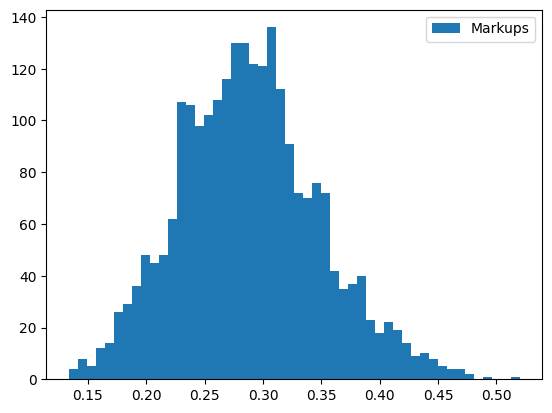

In [15]:
costs = res_optimal_iv.compute_costs()
hhi = res_optimal_iv.compute_hhi()
profits = res_optimal_iv.compute_profits(costs=costs)
cs = res_optimal_iv.compute_consumer_surpluses()

markups = res_optimal_iv.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

[[3.20663234]
 [2.64424071]
 [2.05718073]
 ...
 [2.79248001]
 [2.98194654]
 [2.44527594]]


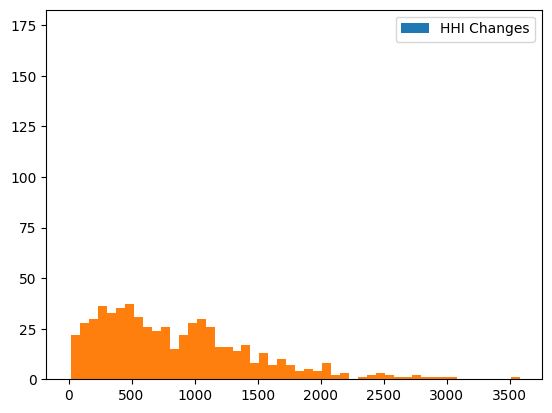

In [16]:
product_data_11 = product_data.copy()

plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_11['merger_ids'] = product_data_11['firm_ids'].replace(2, 1)

changed_prices_11 = res_optimal_iv.compute_prices(
    firm_ids=product_data_11['merger_ids'],
    costs=costs
)
print(changed_prices_11)

changed_shares = res_optimal_iv.compute_shares(changed_prices_11)

changed_hhi = res_optimal_iv.compute_hhi(
    firm_ids=product_data_11['merger_ids'],
    shares=changed_shares
)
plt.hist(changed_hhi - hhi, bins=50);
plt.legend(["HHI Changes"]);

### 12

[[2.87814194]
 [2.61392912]
 [2.0834977 ]
 ...
 [2.76671391]
 [3.0077908 ]
 [2.44573317]]


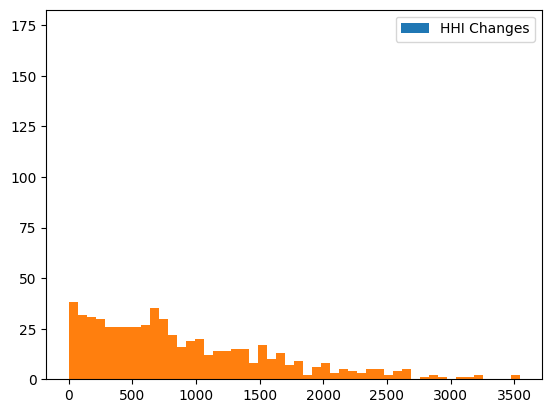

In [17]:
product_data_12 = product_data.copy()

plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_12['merger_ids'] = product_data_12['firm_ids'].replace(3, 1)

changed_prices_12 = res_optimal_iv.compute_prices(
    firm_ids=product_data_12['merger_ids'],
    costs=costs
)
print(changed_prices_12)

changed_shares = res_optimal_iv.compute_shares(changed_prices_12)

changed_hhi = res_optimal_iv.compute_hhi(
    firm_ids=product_data_12['merger_ids'],
    shares=changed_shares
)
plt.hist(changed_hhi - hhi, bins=50);
plt.legend(["HHI Changes"]);

### 14

[[2.94572281]
 [2.46768993]
 [1.85645151]
 ...
 [2.50821945]
 [2.66224454]
 [2.26601513]]


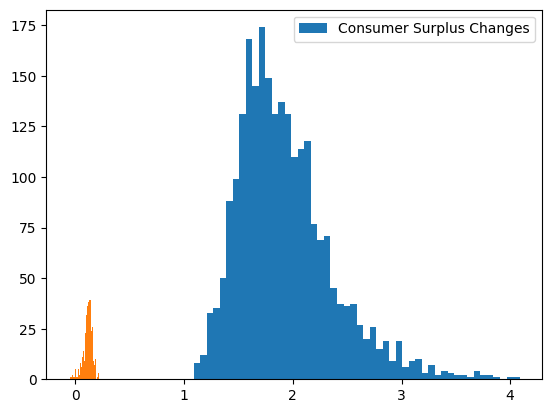

In [18]:
product_data_11 = product_data.copy()

plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_11['merger_ids'] = product_data_11['firm_ids'].replace(2, 1)

changed_prices_14 = res_optimal_iv.compute_prices(
    firm_ids=product_data_11['merger_ids'],
    costs=costs * 0.85
)
print(changed_prices_14)

changed_shares = res_optimal_iv.compute_shares(changed_prices_14)


changed_cs = res_optimal_iv.compute_consumer_surpluses(changed_prices_14)
plt.hist(changed_cs - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);